# Модуль 11. **Рекурентні нейронні мережі** 
_Підбір параметрів_

In [13]:
import copy

import matplotlib.pyplot as plt
from keras import optimizers
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Bidirectional,
    LSTM,
    GRU,
    SimpleRNN,
    Dense,
    GlobalMaxPool1D,
    Dropout,
)
import pandas as pd

     Загальні параметри для тренування моделей 

In [14]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 8,
    "skip_top": 6,
    "batch_size": 16,
    "dropout_rate": 0.0,
    "recurrent_dropout": 0.0,
    "loss_function": "binary_crossentropy",
    "optimizer": "rmsprop",
    "hidden_units": 32,
    "activation": "sigmoid",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "epochs": [6, 8, 10],
    # "epochs": [5, 6, 7, 8],
    # "epochs": [10, 20, 50, 100],
    "batch_size": [16, 32, 64],
    # "batch_size": [8, 32, 64, 128, 256],
    # "dropout_rate": [0.1, 0.2],
    "dropout_rate": [0.0, 0.05, 0.1, 0.2, 0.3],
    "recurrent_dropout": [0.0, 0.05, 0.1, 0.2, 0.3],
    "loss_function": [
        # "sparse_categorical_crossentropy",
        "binary_crossentropy",
        # "mean_squared_error",
    ],
    "optimizer": ["adamw", "rmsprop"],
    # "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],
    # "hidden_units": [64, 128, 256],
    "hidden_units": [32, 64, 128],
    # "activation": ["relu", "sigmoid"],
    "activation": ["relu", "sigmoid", "tanh"],
    "skip_top": [6, 7, 12, 13, 14, 15],
    "metrics": [
        "accuracy",
    ],
}

In [ ]:
# керування виводом даних
verbose = 1
summary = False

In [15]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
CYAN = "\033[36m"
RESET = "\033[0m"

### Допоміжні функції

    Функція друку поточних параметрів
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [16]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [ ]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

     Функція завантаження даних 

In [ ]:
def load_data(skip_top, max_features=10000, maxlen=500, verbose=0):
    # Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів
    (input_train, y_train), (input_test, y_test) = imdb.load_data(
        num_words=max_features, skip_top=skip_top
    )
    # Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів
    input_train = pad_sequences(input_train, maxlen=maxlen)
    input_test = pad_sequences(input_test, maxlen=maxlen)

    if verbose:
        print(f"{input_train.shape = },     {y_train.shape = }")
        print(f" {input_test.shape = },      {y_test.shape = }")
        print('-'*50)
    return input_train, y_train, input_test, y_test

    Функція підготовки моделі
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [19]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    recurrent_dropout,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate, recurrent_dropout)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

     Функція формування optimizer'а 

In [ ]:
def make_optimizer(
    optimizer_str: str, initial_learning_rate, decay_steps, decay_rate=0.9
):

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
    )

    if optimizer_str == "adam":
        optimizer = optimizers.Adam(learning_rate=lr_schedule)
    elif optimizer_str == "sgd":
        optimizer = optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer_str == "rmsprop":
        optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.AdamW(learning_rate=lr_schedule)

    return optimizer

    Функція тренування моделі
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [20]:
def train_model(
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    recurrent_dropout,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    skip_top,
    verbose=0,
    summary=0,
):

    train_images, train_labels, test_images, test_labels = load_data(skip_top, verbose=verbose)

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        recurrent_dropout,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, ' . ', CYAN, train_loss, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, ' . ', CYAN, test_loss, RESET)

    return history, test_acc

     Функція пошуку оптимальних параметрів 

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [21]:
def find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_func,
    verbose=0,
    summary=False,
):

    best_accuracy = 0.0
    best_parameters = {}

    if verbose:
        print_parameters(optimal_parameters)

    for param in study_sequence:

        print(f"{GRAY_BACK}{'=' * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{'=' * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                model_func,
                verbose=verbose,
                summary=summary,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

***
### **Модель для тренування 1** 
***

In [22]:
def model_1(hidden_units, activation, dropout_rate, recurrent_dropout, max_features=10000):

    title_lstm = "Long Short-Term Memory (LSTM)"

    model_lstm = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_lstm.add(Embedding(max_features, hidden_units))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_lstm.add(
        LSTM(hidden_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout)
    )
    model_lstm.add(Dense(1, activation=activation))

    return model_lstm

    Параметри, для навчання моделі 1
###### study_sequence - Послідовність дослідження

In [23]:
study_sequence = [
    "skip_top",
    # "dropout_rate",
    # "recurrent_dropout",
    # "batch_size",
    # "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    # "epochs",
]

    Пошук оптимальних параметрів для вказаної моделі 
###### model_1 - функція що досліджується

Поточні параметри:
 epochs 	= 8
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 recurrent_dropout 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= sigmoid
 metrics 	= ['accuracy']
Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 82ms/step - accuracy: 0.7071 - loss: 0.5392 - val_accuracy: 0.8436 - val_loss: 0.3750
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 224s 143ms/step - accuracy: 0.8761 - loss: 0.3056 - val_accuracy: 0.8760 - val_loss: 0.3100
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step - accuracy: 0.8996 - loss: 0.2598 - val_accuracy: 0.8893 - val_los

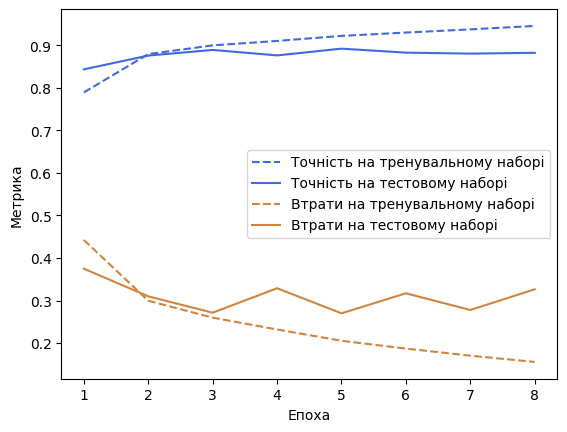

--------------------------------------------------
Тестується значення: dropout_rate = 0.05
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 328s 207ms/step - accuracy: 0.7094 - loss: 0.5373 - val_accuracy: 0.7832 - val_loss: 0.4467
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 299s 191ms/step - accuracy: 0.8764 - loss: 0.3100 - val_accuracy: 0.8738 - val_loss: 0.3071
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 302s 193ms/step - accuracy: 0.8971 - loss: 0.2706 - val_accuracy: 0.8775 - val_loss: 0.2886
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 288s 184ms/step - accuracy: 0.9152 - loss: 0.2304 - val_accuracy: 0.8816 - val_loss: 0.2989
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 283s 181ms/step - accuracy: 0.9192 - loss: 0.2153 - val_accuracy: 0.8897 - val_loss: 0.2852
Epoch 6/8
1563/

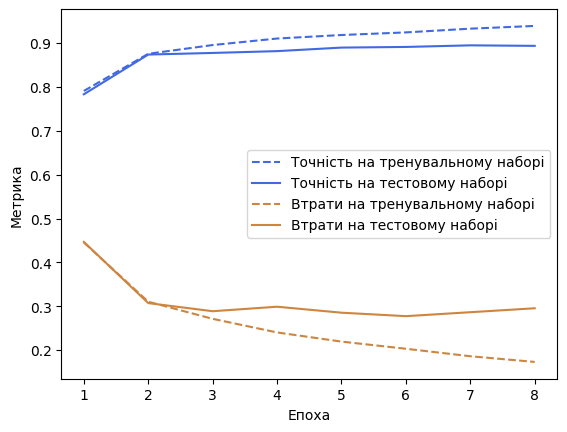

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 310s 195ms/step - accuracy: 0.7190 - loss: 0.5281 - val_accuracy: 0.8629 - val_loss: 0.3268
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 313s 200ms/step - accuracy: 0.8770 - loss: 0.3088 - val_accuracy: 0.8724 - val_loss: 0.2982
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 291s 186ms/step - accuracy: 0.8967 - loss: 0.2667 - val_accuracy: 0.8722 - val_loss: 0.3076
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 313s 200ms/step - accuracy: 0.9090 - loss: 0.2428 - val_accuracy: 0.8780 - val_loss: 0.3097
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 321s 206ms/step - accuracy: 0.9187 - loss: 0.2210 - val_accuracy: 0.8890 - val_loss: 0.3022
Epoch 6/8
1563/1

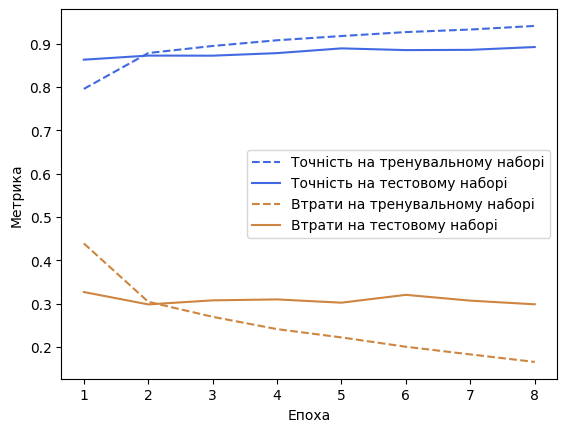

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 186s 118ms/step - accuracy: 0.6976 - loss: 0.5454 - val_accuracy: 0.8725 - val_loss: 0.3049
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 192s 123ms/step - accuracy: 0.8778 - loss: 0.3098 - val_accuracy: 0.8427 - val_loss: 0.3555
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 197s 126ms/step - accuracy: 0.8932 - loss: 0.2717 - val_accuracy: 0.8655 - val_loss: 0.3599
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 192s 123ms/step - accuracy: 0.9072 - loss: 0.2433 - val_accuracy: 0.8149 - val_loss: 0.5358
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 196s 125ms/step - accuracy: 0.9185 - loss: 0.2243 - val_accuracy: 0.8815 - val_loss: 0.2986
Epoch 6/8
1563/1

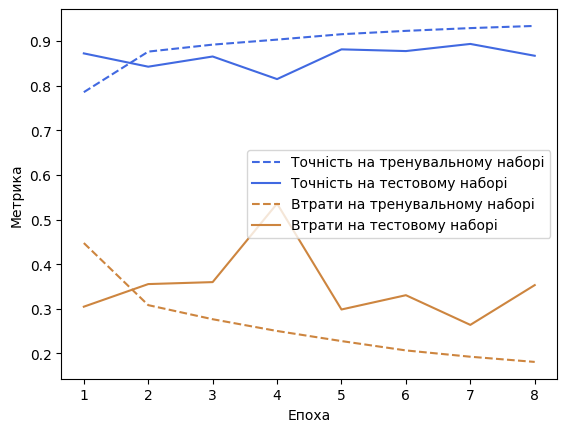

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 204s 130ms/step - accuracy: 0.7017 - loss: 0.5412 - val_accuracy: 0.8594 - val_loss: 0.3353
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 200s 128ms/step - accuracy: 0.8644 - loss: 0.3265 - val_accuracy: 0.8276 - val_loss: 0.3852
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 198s 127ms/step - accuracy: 0.8912 - loss: 0.2794 - val_accuracy: 0.8465 - val_loss: 0.3646
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 204s 131ms/step - accuracy: 0.9029 - loss: 0.2543 - val_accuracy: 0.8865 - val_loss: 0.2785
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 197s 126ms/step - accuracy: 0.9121 - loss: 0.2292 - val_accuracy: 0.8832 - val_loss: 0.2985
Epoch 6/8
1563/1

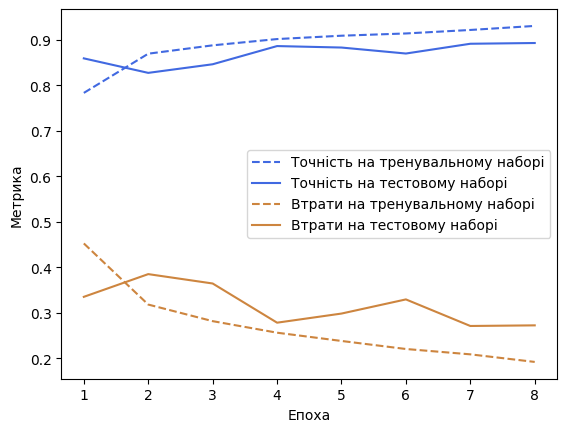

 Оптимальне значення параметра dropout_rate = 0.05
   точність на тестових даних: 0.8936399817466736

Пошук оптимального значення параметра: recurrent_dropout 
--------------------------------------------------
Тестується значення: recurrent_dropout = 0.0
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10546s 7s/step - accuracy: 0.7174 - loss: 0.5307 - val_accuracy: 0.7637 - val_loss: 0.5238
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 92ms/step - accuracy: 0.8756 - loss: 0.3093 - val_accuracy: 0.8842 - val_loss: 0.2956
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 0.8928 - loss: 0.2746 - val_accuracy: 0.8839 - val_loss: 0.2978
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.9072 - loss: 0.2361 - val_accuracy: 0.8621 - val_l

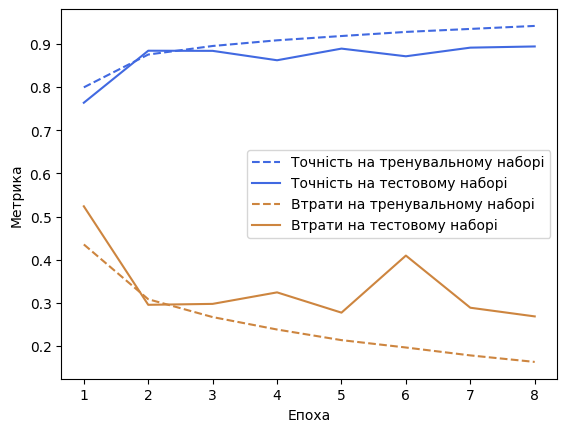

--------------------------------------------------
Тестується значення: recurrent_dropout = 0.05
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 172s 109ms/step - accuracy: 0.6937 - loss: 0.5522 - val_accuracy: 0.8438 - val_loss: 0.3641
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 205s 131ms/step - accuracy: 0.8610 - loss: 0.3395 - val_accuracy: 0.8709 - val_loss: 0.3089
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 198s 127ms/step - accuracy: 0.8844 - loss: 0.2881 - val_accuracy: 0.8808 - val_loss: 0.2903
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 191s 122ms/step - accuracy: 0.9048 - loss: 0.2483 - val_accuracy: 0.8682 - val_loss: 0.3374
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 195s 125ms/step - accuracy: 0.9146 - loss: 0.2246 - val_accuracy: 0.8812 - val_loss: 0.3153
Epoch 6/8


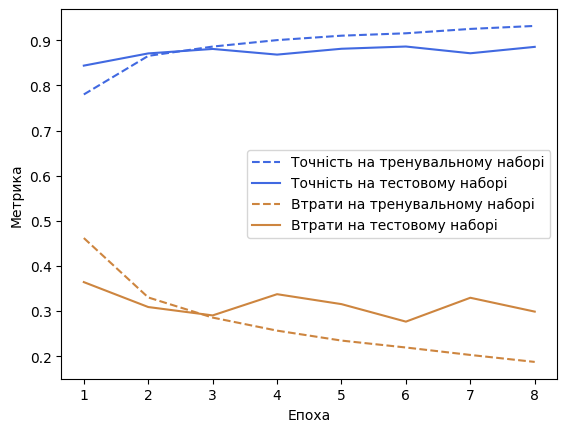

--------------------------------------------------
Тестується значення: recurrent_dropout = 0.1
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 183s 116ms/step - accuracy: 0.6977 - loss: 0.5531 - val_accuracy: 0.8602 - val_loss: 0.3425
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 187s 120ms/step - accuracy: 0.8551 - loss: 0.3457 - val_accuracy: 0.8556 - val_loss: 0.3350
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.8778 - loss: 0.3062 - val_accuracy: 0.8676 - val_loss: 0.3141
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 189s 121ms/step - accuracy: 0.8893 - loss: 0.2796 - val_accuracy: 0.8755 - val_loss: 0.3021
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 249s 159ms/step - accuracy: 0.9049 - loss: 0.2473 - val_accuracy: 0.8865 - val_loss: 0.2949
Epoch 6/8
1

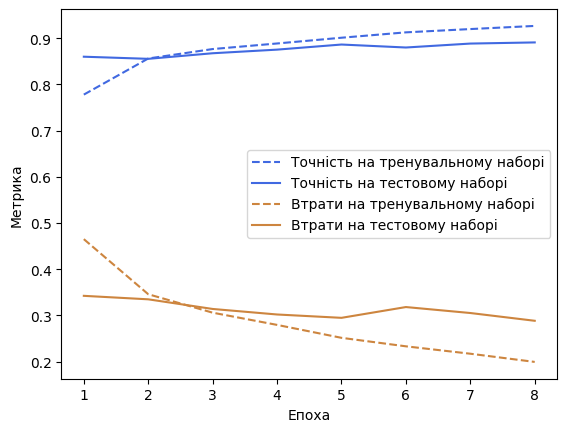

--------------------------------------------------
Тестується значення: recurrent_dropout = 0.2
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 276s 175ms/step - accuracy: 0.6990 - loss: 0.5630 - val_accuracy: 0.8393 - val_loss: 0.3727
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 259s 166ms/step - accuracy: 0.8510 - loss: 0.3670 - val_accuracy: 0.8574 - val_loss: 0.3399
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 167ms/step - accuracy: 0.8671 - loss: 0.3244 - val_accuracy: 0.8692 - val_loss: 0.3218
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 242s 155ms/step - accuracy: 0.8840 - loss: 0.2977 - val_accuracy: 0.8721 - val_loss: 0.3201
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 243s 155ms/step - accuracy: 0.8948 - loss: 0.2735 - val_accuracy: 0.8665 - val_loss: 0.3259
Epoch 6/8
1

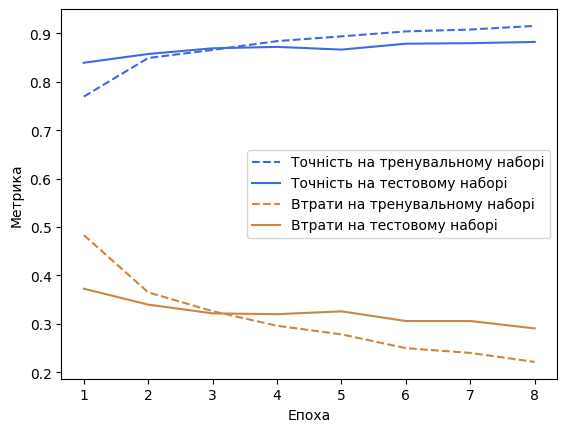

--------------------------------------------------
Тестується значення: recurrent_dropout = 0.3
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 299s 190ms/step - accuracy: 0.6892 - loss: 0.5783 - val_accuracy: 0.8239 - val_loss: 0.4014
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 298s 191ms/step - accuracy: 0.8370 - loss: 0.3860 - val_accuracy: 0.8410 - val_loss: 0.3699
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 297s 190ms/step - accuracy: 0.8615 - loss: 0.3412 - val_accuracy: 0.8475 - val_loss: 0.3676
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 305s 195ms/step - accuracy: 0.8750 - loss: 0.3162 - val_accuracy: 0.8623 - val_loss: 0.3358
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 306s 196ms/step - accuracy: 0.8824 - loss: 0.2922 - val_accuracy: 0.8589 - val_loss: 0.3409
Epoch 6/8
1

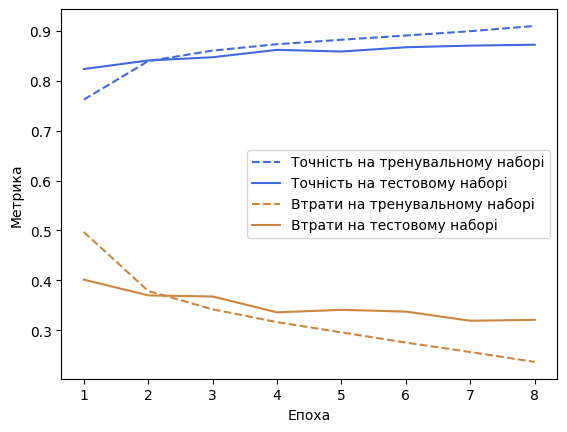

 Оптимальне значення параметра recurrent_dropout = 0.0
   точність на тестових даних: 0.8940799832344055

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 317s 201ms/step - accuracy: 0.7135 - loss: 0.6440 - val_accuracy: 0.8490 - val_loss: 0.3868
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 323s 207ms/step - accuracy: 0.8682 - loss: 0.4187 - val_accuracy: 0.8811 - val_loss: 0.3869
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 358s 229ms/step - accuracy: 0.8892 - loss: 0.4051 - val_accuracy: 0.8685 - val_loss: 0.3694
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 343s 219ms/step - accuracy: 0.9021 - loss: 0.4377 - val_accuracy: 0.8844 - val_loss: 

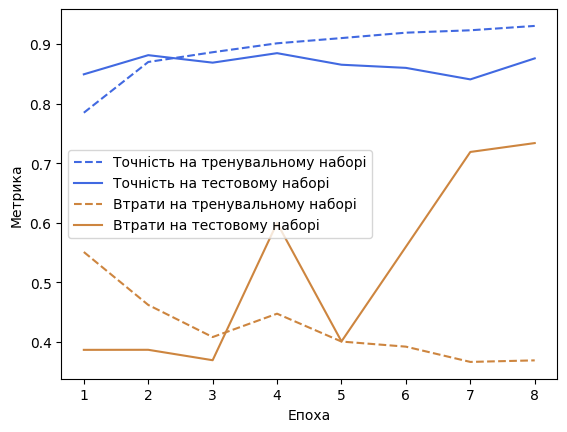

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 271s 172ms/step - accuracy: 0.6994 - loss: 0.5497 - val_accuracy: 0.8054 - val_loss: 0.4256
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 253s 162ms/step - accuracy: 0.8721 - loss: 0.3123 - val_accuracy: 0.8777 - val_loss: 0.3056
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 240s 154ms/step - accuracy: 0.8975 - loss: 0.2628 - val_accuracy: 0.8719 - val_loss: 0.3031
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 129ms/step - accuracy: 0.9120 - loss: 0.2347 - val_accuracy: 0.8753 - val_loss: 0.3176
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 216s 138ms/step - accuracy: 0.9268 - loss: 0.2014 - val_accuracy: 0.8848 - val_loss: 0.2848
Epoch 6/8
1563

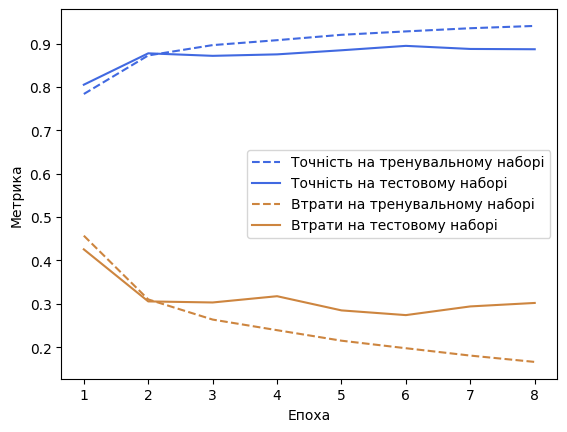

--------------------------------------------------
Тестується значення: activation = tanh
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 222s 141ms/step - accuracy: 0.7168 - loss: 0.6380 - val_accuracy: 0.8488 - val_loss: 0.3678
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 242s 155ms/step - accuracy: 0.8696 - loss: 0.3727 - val_accuracy: 0.8258 - val_loss: 0.3799
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 212s 136ms/step - accuracy: 0.8834 - loss: 0.3628 - val_accuracy: 0.8667 - val_loss: 0.3506
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 213s 136ms/step - accuracy: 0.9018 - loss: 0.3583 - val_accuracy: 0.7708 - val_loss: 1.5691
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 221s 142ms/step - accuracy: 0.9075 - loss: 0.3760 - val_accuracy: 0.8823 - val_loss: 0.3827
Epoch 6/8
1563/15

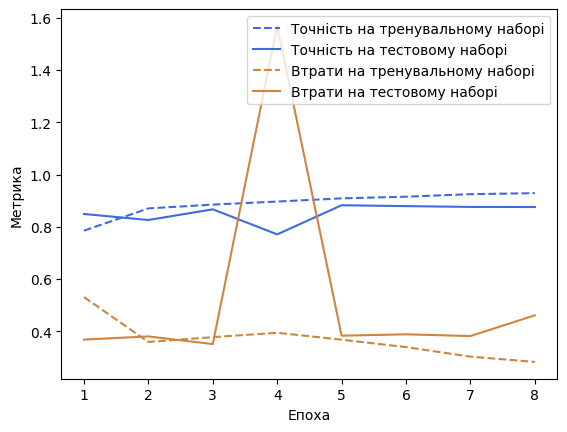

 Оптимальне значення параметра activation = sigmoid
   точність на тестових даних: 0.8940799832344055

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 6
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 256s 163ms/step - accuracy: 0.7120 - loss: 0.5350 - val_accuracy: 0.8626 - val_loss: 0.3375
Epoch 2/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 256s 164ms/step - accuracy: 0.8778 - loss: 0.3089 - val_accuracy: 0.8844 - val_loss: 0.2940
Epoch 3/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step - accuracy: 0.8992 - loss: 0.2694 - val_accuracy: 0.8700 - val_loss: 0.3255
Epoch 4/6
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step - accuracy: 0.9088 - loss: 0.2408 - val_accuracy: 0.8920 - val_loss: 0.2756
Epoch 5

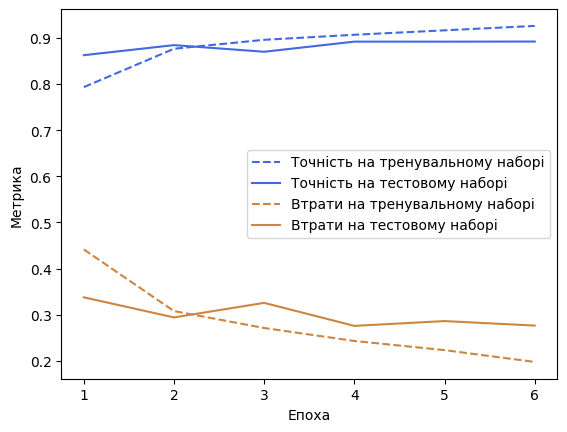

--------------------------------------------------
Тестується значення: epochs = 8
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 274s 174ms/step - accuracy: 0.7098 - loss: 0.5368 - val_accuracy: 0.8574 - val_loss: 0.3438
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 340s 217ms/step - accuracy: 0.8791 - loss: 0.3055 - val_accuracy: 0.8820 - val_loss: 0.2943
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 355s 227ms/step - accuracy: 0.8998 - loss: 0.2597 - val_accuracy: 0.8564 - val_loss: 0.3848
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 354s 227ms/step - accuracy: 0.9123 - loss: 0.2351 - val_accuracy: 0.8806 - val_loss: 0.2856
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 343s 219ms/step - accuracy: 0.9236 - loss: 0.2106 - val_accuracy: 0.8882 - val_loss: 0.2784
Epoch 6/8
1563/1563 ━━━━

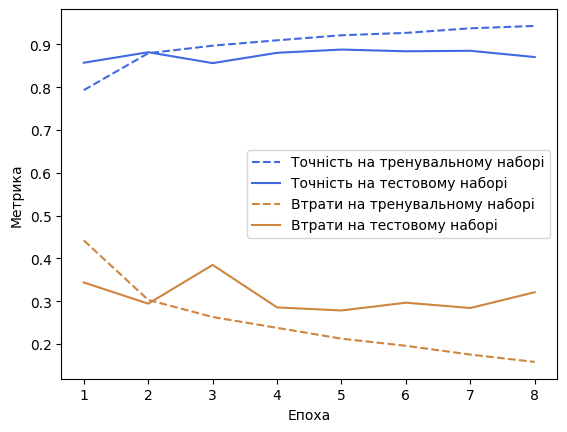

--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 338s 214ms/step - accuracy: 0.7143 - loss: 0.5319 - val_accuracy: 0.8701 - val_loss: 0.3217
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 340s 217ms/step - accuracy: 0.8759 - loss: 0.3018 - val_accuracy: 0.8647 - val_loss: 0.3476
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 344s 220ms/step - accuracy: 0.8953 - loss: 0.2714 - val_accuracy: 0.8791 - val_loss: 0.2914
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 365s 234ms/step - accuracy: 0.9055 - loss: 0.2451 - val_accuracy: 0.8802 - val_loss: 0.2997
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 326s 208ms/step - accuracy: 0.9178 - loss: 0.2186 - val_accuracy: 0.8825 - val_loss: 0.2902
Epoch 6/10
1563/15

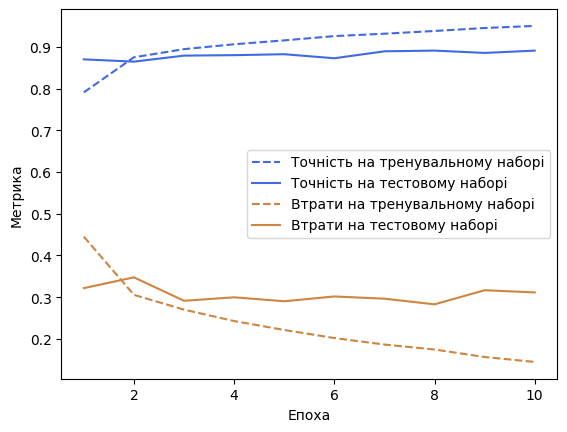

 Оптимальне значення параметра epochs = 8
   точність на тестових даних: 0.8940799832344055



In [24]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_1,
    verbose=verbose,
    summary=summary,
)

In [25]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_1
 epochs 	= 8
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.05
 recurrent_dropout 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8940799832344055


<div class="alert alert-block alert-info">
<b>Оптимальні параметри для model_1</b>

```
 epochs 	= 8
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.05
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8940799832344055
 ```
</div>

***
### **Модель для тренування 2** 
***


In [26]:
def model_2(
    hidden_units, activation, dropout_rate, recurrent_dropout, max_features=10000
):

    title_gru = "Gated Recurrent Unit (GRU)"

    model_gru = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_gru.add(Embedding(max_features, hidden_units))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_gru.add(
        GRU(hidden_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout)
    )
    model_gru.add(Dense(1, activation=activation))

    return model_gru

In [27]:
study_sequence = [
    # "batch_size",
    # "skip_top",
    "dropout_rate",
    "recurrent_dropout",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    # "epochs",
]

Поточні параметри:
 epochs 	= 8
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.05
 recurrent_dropout 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= sigmoid
 metrics 	= ['accuracy']
Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 455s 288ms/step - accuracy: 0.6884 - loss: 0.5550 - val_accuracy: 0.8113 - val_loss: 0.4169
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 479s 306ms/step - accuracy: 0.8774 - loss: 0.3038 - val_accuracy: 0.8618 - val_loss: 0.3647
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 446s 285ms/step - accuracy: 0.9120 - loss: 0.2283 - val_accuracy: 0.8924 - val_l

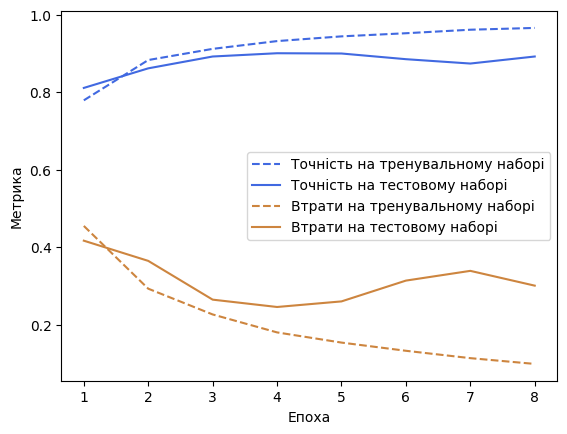

--------------------------------------------------
Тестується значення: dropout_rate = 0.05
--------------------------------------------------
input_train.shape = (25000, 500),     y_train.shape = (25000,)
 input_test.shape = (25000, 500),      y_test.shape = (25000,)
--------------------------------------------------
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 302s 190ms/step - accuracy: 0.6895 - loss: 0.5543 - val_accuracy: 0.8518 - val_loss: 0.3556
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 287s 183ms/step - accuracy: 0.8770 - loss: 0.3118 - val_accuracy: 0.8455 - val_loss: 0.3617
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 312s 200ms/step - accuracy: 0.9030 - loss: 0.2531 - val_accuracy: 0.8865 - val_loss: 0.2875
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 290s 186ms/step - accuracy: 0.9241 - loss: 0.2022 - val_accuracy: 0.8968 - val_loss: 0.2530
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 282s 180ms/step - accuracy: 0.9361 - loss: 0.1714 - val_accuracy: 0.9017 - val_loss: 0.2484
Epoch 6/8
1563/

In [28]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_2,
    verbose=1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Оптимальні параметри для model_2:</b> 

```
 epochs 	= 6
 skip_top 	= 6
 batch_size 	= 16
 dropout_rate 	= 0.0
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8981599807739258
 ```
</div>

***
### **Модель для тренування 3** 
***

In [ ]:
def model_3(hidden_units, activation, dropout_rate, max_features=10000):

    title_drnn = "Deep Recurrent Neural Network + LSTM (DRNN)"

    model_drnn = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_drnn.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_drnn.add(Bidirectional(LSTM(32, return_sequences=True)))
    model_drnn.add(Dropout(dropout_rate))
    model_drnn.add(Bidirectional(LSTM(32)))
    model_drnn.add(Dense(1, activation=activation))

    return model_drnn

In [ ]:
study_sequence = [
    # "batch_size",
    # "skip_top",
    "dropout_rate",
    # "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_3,
    verbose=1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_3")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_3:</b> 
<p>Отрим6 стало 512</p>
</div>

***
### **Модель для тренування 4** 
***

In [ ]:
def model_4(hidden_units, activation, dropout_rate, max_features=10000):

    title_kgl = "From Kaggle"

    # embed_size = 128
    embed_size = hidden_units
    model_kgl = Sequential()
    model_kgl.add(Embedding(max_features, embed_size))
    model_kgl.add(Bidirectional(LSTM(32, return_sequences=True)))
    model_kgl.add(GlobalMaxPool1D())
    model_kgl.add(Dense(20, activation=activation))
    model_kgl.add(Dropout(dropout_rate))
    model_kgl.add(Dense(1, activation="sigmoid"))

    return model_kgl

In [ ]:
study_sequence = [
    # "batch_size",
    # "skip_top",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    "activation",
    # "metrics",
    "epochs",
]

In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_4,
    verbose=1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_4")
print(f" Точність:        {YELLOW}{best_accuracy}")